# Inference on Algeria S2 Validation Data

Run the trained Swin Transformer model on the Algeria validation set to evaluate performance.

In [23]:
print("fgso")

fgso


In [24]:
# =============================================================================
# Cell 1: Imports and Setup
# =============================================================================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import timm
import warnings
warnings.filterwarnings('ignore')

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Paths
ALGERIA_DATA_DIR = Path('/home/crop/Desktop/crop2/output/algeria_s2_data/DATA_S2')
ALGERIA_ANN_DIR = Path('/home/crop/Desktop/crop2/output/algeria_s2_data/ANNOTATIONS')
MODEL_PATH = Path('output/swin_cereal_classifier.pth')

print(f"\nModel path: {MODEL_PATH}")
print(f"Model exists: {MODEL_PATH.exists()}")

Using device: cuda
GPU: NVIDIA GeForce RTX 5090

Model path: output/swin_cereal_classifier.pth
Model exists: True


In [25]:
# =============================================================================
# Cell 2: Define Model Architecture (must match training)
# =============================================================================

def create_swin_model(in_channels=10, num_classes=1, pretrained=False, img_size=128):
    """Create Swin Transformer with 10-channel input"""
    
    model = timm.create_model(
        'swin_tiny_patch4_window7_224',
        pretrained=pretrained,
        num_classes=num_classes,
        img_size=img_size,
    )
    
    # Modify patch embedding for 10 channels
    orig_proj = model.patch_embed.proj
    new_proj = nn.Conv2d(
        in_channels=in_channels,
        out_channels=orig_proj.out_channels,
        kernel_size=orig_proj.kernel_size,
        stride=orig_proj.stride,
        padding=orig_proj.padding
    )
    model.patch_embed.proj = new_proj
    
    return model

print("✓ Model architecture defined")

✓ Model architecture defined


In [26]:
# =============================================================================
# Cell 3: Load Trained Model
# =============================================================================

# Load checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)

print("Checkpoint contents:")
for key in checkpoint.keys():
    if key == 'model_state_dict':
        print(f"  {key}: {len(checkpoint[key])} layers")
    elif key == 'history':
        print(f"  {key}: {len(checkpoint[key])} metrics tracked")
    else:
        print(f"  {key}: {checkpoint[key]}")

# Get config from checkpoint
config = checkpoint.get('config', {
    'in_channels': 10,
    'num_classes': 1,
    'img_size': 128
})

# Create and load model
model = create_swin_model(
    in_channels=config.get('in_channels', 10),
    num_classes=config.get('num_classes', 1),
    pretrained=False,
    img_size=config.get('img_size', 128)
)

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"\n✓ Model loaded successfully")
print(f"  Best F1 during training: {checkpoint.get('best_f1', 'N/A')}")

Checkpoint contents:
  model_state_dict: 173 layers
  config: {'batch_size': 16, 'learning_rate': 1e-05, 'weight_decay': 0.01, 'epochs': 30, 'num_workers': 4, 'img_size': 128, 'in_channels': 10, 'num_classes': 1, 'fda_ratio': 0.5, 'parcel_threshold': 0.2}
  history: 10 metrics tracked
  best_f1: 0.961038961038961
  results: {'accuracy': np.float64(0.967391304347826), 'precision': np.float64(1.0), 'recall': np.float64(0.925), 'f1': np.float64(0.961038961038961), 'confusion': (np.int64(37), np.int64(0), np.int64(3), np.int64(52))}

✓ Model loaded successfully
  Best F1 during training: 0.961038961038961


In [27]:
# =============================================================================
# Cell 4: Load Validation Dataset
# =============================================================================

class AlgeriaDataset(Dataset):
    """Algeria S2 Dataset for inference - respects metadata-based split"""
    
    def __init__(self, data_dir, ann_dir, split='val'):
        self.data_dir = Path(data_dir)
        self.ann_dir = Path(ann_dir)
        
        # Load split mapping from metadata.geojson
        metadata_path = self.data_dir.parent / 'metadata.geojson'
        split_map = {}  # filename -> split
        
        if metadata_path.exists():
            import json
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
            for feature in metadata['features']:
                filename = feature['properties']['filename']
                file_split = feature['properties']['split']
                split_map[filename] = file_split
            print(f"Loaded split info for {len(split_map)} files from metadata")
        else:
            print(f"⚠️ WARNING: metadata.geojson not found at {metadata_path}")
            print("  Falling back to filename-based split (first 101 train, rest val)")
        
        # Get all data files and match with annotations
        self.data_files = sorted(self.data_dir.glob('*.npy'))
        self.samples = []
        
        for data_file in self.data_files:
            # Check if this file belongs to the requested split
            if split_map:
                file_split = split_map.get(data_file.name, None)
                # Handle 'val' vs 'validation' naming
                if split == 'val' and file_split == 'validation':
                    pass  # This file belongs to validation
                elif split == 'train' and file_split == 'train':
                    pass  # This file belongs to training
                else:
                    continue  # Skip files not in requested split
            else:
                # Fallback: use index-based split
                file_idx = int(data_file.stem.replace('S2_', ''))
                if split == 'val' and file_idx < 101:
                    continue
                if split == 'train' and file_idx >= 101:
                    continue
            
            file_id = data_file.stem.replace('S2_', '')
            ann_file = self.ann_dir / f'Labels_{file_id}.npy'
            if ann_file.exists():
                self.samples.append((data_file, ann_file))
        
        print(f"AlgeriaDataset ({split}): {len(self.samples)} samples")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        data_file, ann_file = self.samples[idx]
        
        # Load image: (1, 10, 128, 128) -> (10, 128, 128)
        img = np.load(data_file)[0].astype(np.float32)
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        
        # Load label
        ann = np.load(ann_file)
        label = float(ann.item()) if ann.ndim == 0 else float(ann.max())
        
        return torch.from_numpy(img), torch.tensor(label, dtype=torch.float32), data_file.stem

# Create validation dataset and loader
val_dataset = AlgeriaDataset(ALGERIA_DATA_DIR, ALGERIA_ANN_DIR, split='val')
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"\nValidation batches: {len(val_loader)}")

Loaded split info for 193 files from metadata
AlgeriaDataset (val): 92 samples

Validation batches: 6


In [28]:
# =============================================================================
# Cell 5: Run Inference
# =============================================================================

all_preds = []
all_labels = []
all_probs = []
all_names = []

print("Running inference on validation set...")
print("=" * 60)

with torch.no_grad():
    for imgs, labels, names in val_loader:
        imgs = imgs.to(device)
        
        # Forward pass
        outputs = model(imgs)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        preds = (probs > 0.5).astype(float)
        
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
        all_names.extend(names)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print(f"✓ Inference complete on {len(all_preds)} samples")

Running inference on validation set...
✓ Inference complete on 92 samples


In [29]:
# =============================================================================
# Cell 6: Calculate Metrics
# =============================================================================

# Confusion matrix components
tp = ((all_preds == 1) & (all_labels == 1)).sum()
fp = ((all_preds == 1) & (all_labels == 0)).sum()
fn = ((all_preds == 0) & (all_labels == 1)).sum()
tn = ((all_preds == 0) & (all_labels == 0)).sum()

# Metrics
accuracy = (all_preds == all_labels).mean()
precision = tp / max(tp + fp, 1)
recall = tp / max(tp + fn, 1)
f1 = 2 * precision * recall / max(precision + recall, 1e-8)
specificity = tn / max(tn + fp, 1)

print("=" * 60)
print("VALIDATION RESULTS")
print("=" * 60)
print(f"\nTotal Samples: {len(all_preds)}")
print(f"  - Actual Cereal: {int(all_labels.sum())}")
print(f"  - Actual Non-Cereal: {int(len(all_labels) - all_labels.sum())}")

print(f"\n📊 Classification Metrics:")
print(f"  Accuracy:    {accuracy*100:.1f}%")
print(f"  Precision:   {precision*100:.1f}%")
print(f"  Recall:      {recall*100:.1f}%")
print(f"  F1 Score:    {f1*100:.1f}%")
print(f"  Specificity: {specificity*100:.1f}%")

print(f"\n📋 Confusion Matrix:")
print(f"                    Predicted")
print(f"                 Non-Cereal  Cereal")
print(f"Actual Non-Cereal    {int(tn):4d}      {int(fp):4d}")
print(f"Actual Cereal        {int(fn):4d}      {int(tp):4d}")

VALIDATION RESULTS

Total Samples: 92
  - Actual Cereal: 40
  - Actual Non-Cereal: 52

📊 Classification Metrics:
  Accuracy:    96.7%
  Precision:   100.0%
  Recall:      92.5%
  F1 Score:    96.1%
  Specificity: 100.0%

📋 Confusion Matrix:
                    Predicted
                 Non-Cereal  Cereal
Actual Non-Cereal      52         0
Actual Cereal           3        37


In [30]:
# =============================================================================
# Cell 7: Detailed Predictions Table
# =============================================================================

print("=" * 60)
print("SAMPLE-BY-SAMPLE PREDICTIONS")
print("=" * 60)
print(f"{'Sample':<12} {'True':<12} {'Predicted':<12} {'Prob':<8} {'Correct'}")
print("-" * 60)

for i in range(len(all_names)):
    true_label = "Cereal" if all_labels[i] == 1 else "Non-Cereal"
    pred_label = "Cereal" if all_preds[i] == 1 else "Non-Cereal"
    correct = "✓" if all_preds[i] == all_labels[i] else "✗"
    print(f"{all_names[i]:<12} {true_label:<12} {pred_label:<12} {all_probs[i]:.3f}    {correct}")

# Summary of errors
print("\n" + "=" * 60)
print("ERROR ANALYSIS")
print("=" * 60)

false_positives = [(all_names[i], all_probs[i]) for i in range(len(all_names)) 
                   if all_preds[i] == 1 and all_labels[i] == 0]
false_negatives = [(all_names[i], all_probs[i]) for i in range(len(all_names)) 
                   if all_preds[i] == 0 and all_labels[i] == 1]

print(f"\nFalse Positives (predicted Cereal, actually Non-Cereal): {len(false_positives)}")
for name, prob in false_positives[:10]:
    print(f"  {name}: prob={prob:.3f}")

print(f"\nFalse Negatives (predicted Non-Cereal, actually Cereal): {len(false_negatives)}")
for name, prob in false_negatives[:10]:
    print(f"  {name}: prob={prob:.3f}")

SAMPLE-BY-SAMPLE PREDICTIONS
Sample       True         Predicted    Prob     Correct
------------------------------------------------------------
S2_00102     Cereal       Cereal       1.000    ✓
S2_00103     Cereal       Cereal       1.000    ✓
S2_00104     Cereal       Cereal       1.000    ✓
S2_00105     Cereal       Cereal       1.000    ✓
S2_00106     Cereal       Cereal       1.000    ✓
S2_00107     Cereal       Cereal       1.000    ✓
S2_00108     Cereal       Cereal       1.000    ✓
S2_00109     Cereal       Cereal       1.000    ✓
S2_00110     Cereal       Non-Cereal   0.180    ✗
S2_00111     Cereal       Cereal       1.000    ✓
S2_00112     Cereal       Cereal       1.000    ✓
S2_00113     Cereal       Cereal       0.999    ✓
S2_00114     Cereal       Cereal       1.000    ✓
S2_00115     Cereal       Cereal       0.995    ✓
S2_00116     Cereal       Non-Cereal   0.021    ✗
S2_00117     Cereal       Cereal       1.000    ✓
S2_00118     Cereal       Cereal       1.000    ✓
S2_0

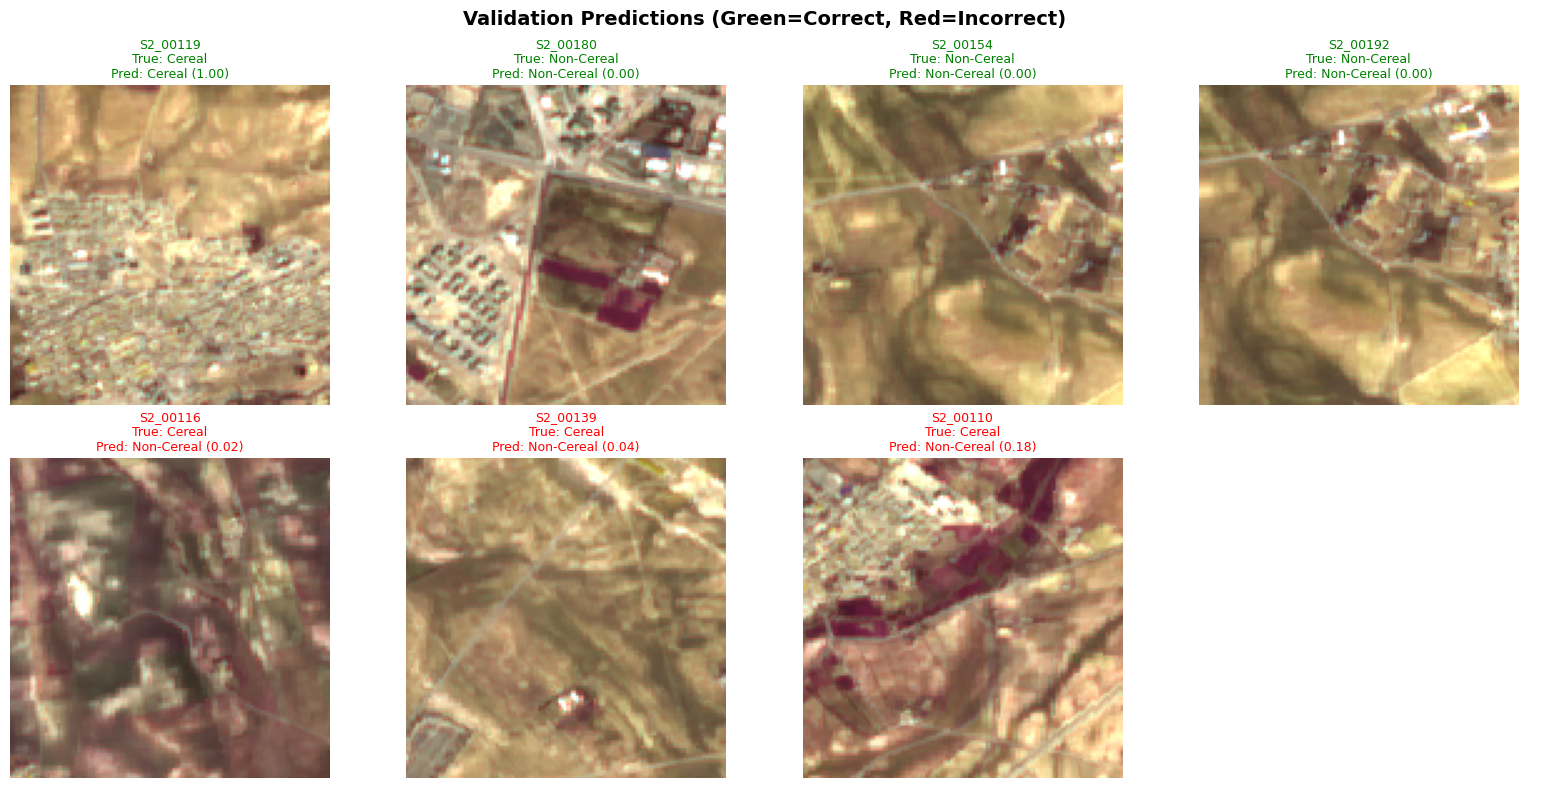


✓ Saved to output/inference_predictions.png


In [31]:
# =============================================================================
# Cell 8: Visualize Sample Predictions
# =============================================================================

import random

def visualize_predictions(dataset, predictions, labels, probs, num_samples=8):
    """Visualize predictions with RGB composite"""
    
    # Get indices for correct and incorrect predictions
    correct_idx = [i for i in range(len(predictions)) if predictions[i] == labels[i]]
    incorrect_idx = [i for i in range(len(predictions)) if predictions[i] != labels[i]]
    
    # Sample from both
    n_correct = min(4, len(correct_idx))
    n_incorrect = min(4, len(incorrect_idx))
    
    sample_idx = random.sample(correct_idx, n_correct) if correct_idx else []
    sample_idx += random.sample(incorrect_idx, n_incorrect) if incorrect_idx else []
    
    if len(sample_idx) == 0:
        print("No samples to visualize")
        return
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for ax_idx, sample_idx_val in enumerate(sample_idx[:8]):
        img, label, name = dataset[sample_idx_val]
        
        # RGB composite (bands 4, 3, 2 -> Red, Green, Blue)
        rgb = img[[3, 2, 1], :, :].numpy()
        rgb = np.transpose(rgb, (1, 2, 0))
        rgb = np.clip(rgb * 3, 0, 1)  # Brightness boost
        
        axes[ax_idx].imshow(rgb)
        
        true_str = "Cereal" if labels[sample_idx_val] == 1 else "Non-Cereal"
        pred_str = "Cereal" if predictions[sample_idx_val] == 1 else "Non-Cereal"
        correct = predictions[sample_idx_val] == labels[sample_idx_val]
        
        color = 'green' if correct else 'red'
        axes[ax_idx].set_title(f"{name}\nTrue: {true_str}\nPred: {pred_str} ({probs[sample_idx_val]:.2f})", 
                               fontsize=9, color=color)
        axes[ax_idx].axis('off')
        
        for spine in axes[ax_idx].spines.values():
            spine.set_visible(True)
            spine.set_color(color)
            spine.set_linewidth(3)
    
    # Hide unused axes
    for ax_idx in range(len(sample_idx), 8):
        axes[ax_idx].axis('off')
    
    plt.suptitle('Validation Predictions (Green=Correct, Red=Incorrect)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/home/crop/Desktop/crop2/output/inference_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✓ Saved to output/inference_predictions.png")

# Visualize
visualize_predictions(val_dataset, all_preds, all_labels, all_probs)

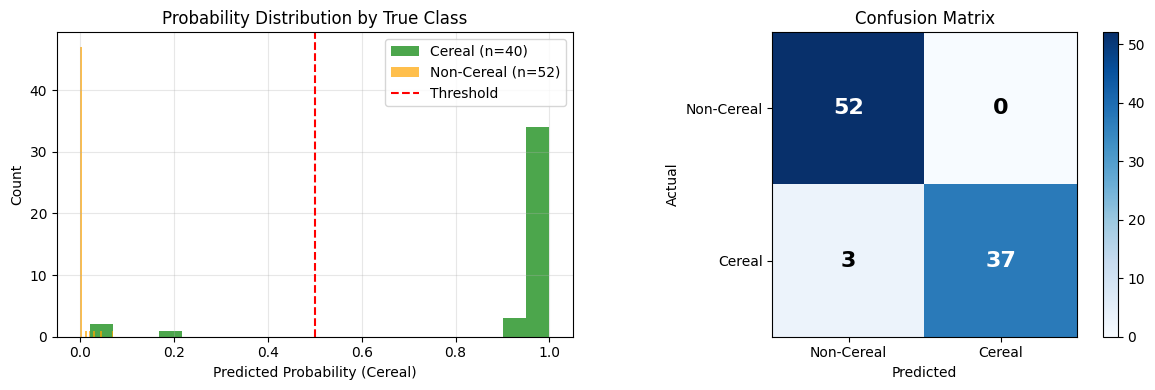

✓ Saved to output/inference_analysis.png


In [32]:
# =============================================================================
# Cell 9: Probability Distribution
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of probabilities by true class
cereal_probs = all_probs[all_labels == 1]
non_cereal_probs = all_probs[all_labels == 0]

axes[0].hist(cereal_probs, bins=20, alpha=0.7, label=f'Cereal (n={len(cereal_probs)})', color='green')
axes[0].hist(non_cereal_probs, bins=20, alpha=0.7, label=f'Non-Cereal (n={len(non_cereal_probs)})', color='orange')
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Threshold')
axes[0].set_xlabel('Predicted Probability (Cereal)')
axes[0].set_ylabel('Count')
axes[0].set_title('Probability Distribution by True Class')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confusion matrix heatmap
conf_matrix = np.array([[tn, fp], [fn, tp]])
im = axes[1].imshow(conf_matrix, cmap='Blues')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Non-Cereal', 'Cereal'])
axes[1].set_yticklabels(['Non-Cereal', 'Cereal'])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix')

# Add text annotations
for i in range(2):
    for j in range(2):
        text = axes[1].text(j, i, int(conf_matrix[i, j]),
                           ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max()/2 else "black",
                           fontsize=16, fontweight='bold')

plt.colorbar(im, ax=axes[1])
plt.tight_layout()
plt.savefig('/home/crop/Desktop/crop2/output/inference_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved to output/inference_analysis.png")

In [33]:
# =============================================================================
# Cell 10: Save Results
# =============================================================================

import json

# Save detailed results
results = {
    'model_path': str(MODEL_PATH),
    'num_samples': len(all_preds),
    'metrics': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'specificity': float(specificity)
    },
    'confusion_matrix': {
        'true_positive': int(tp),
        'false_positive': int(fp),
        'false_negative': int(fn),
        'true_negative': int(tn)
    },
    'predictions': [
        {
            'sample': all_names[i],
            'true_label': int(all_labels[i]),
            'predicted_label': int(all_preds[i]),
            'probability': float(all_probs[i])
        }
        for i in range(len(all_names))
    ]
}

results_path = Path('/home/crop/Desktop/crop2/output/inference_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"✓ Results saved to: {results_path}")
print(f"\nSummary:")
print(f"  Accuracy: {accuracy*100:.1f}%")
print(f"  F1 Score: {f1*100:.1f}%")

✓ Results saved to: /home/crop/Desktop/crop2/output/inference_results.json

Summary:
  Accuracy: 96.7%
  F1 Score: 96.1%
